# Model Building

Discuss possible analytical approaches for model development


* Modelling Process
* Model comparisons
* Model interpretation
* Business insights and Recommendations

---

## Model Building Criteria 

The premium paid by the customer is the major revenue source for insurance companies.  
Since the default in premium payments incurr significant revenue losses, insurance companies would like to know upfront which type of customers would default premium payments.

In this project, the target variable is heavily imbalanced. Therefore the most appropriate metric for model building will be the F1 score which will provide a balance between the Recall and Precision.

<font color='red'>The metric to be maximized is **F1 Score**.

---

## Model Building Preparation

**Define functions**
* Confusion matrix
* Metric scores(accuracy, recall and precision)


**Confusion Matrix definition:**

| **Parameter**| **Description** | 
| :-: | :-: |
| **True Positive** | Predict policy holder will **default** on premium payment and the policy holder actually **defaulted** on their premium payment|
| **False Positive** | Predict policy holder will **default** on premium payment and the policy holder **did not default**  on their premium payment|
| **True Negative** | Predict policy holder will **not default** on premium payment and the policy holder actually **did not default** on their premium payment|
| **False Negative** | Predict policy holder will **not default** on premium payment and the policy holder **defaulted** on their premium payment|

---

In [108]:
# Function to calculate different metric scores of the model - Accuracy, Recall, Precision and F1 Score
def get_metrics_score(model, train, test, train_y, test_y, flag=True):
    '''
    model : classifier to predict values of X

    '''
    # defining an empty list to store train and test results
    score_list = []

    pred_train = model.predict(train)
    pred_test = model.predict(test)

    train_acc = model.score(train, train_y)
    test_acc = model.score(test, test_y)

    train_recall = metrics.recall_score(train_y, pred_train)
    test_recall = metrics.recall_score(test_y, pred_test)

    train_precision = metrics.precision_score(train_y, pred_train)
    test_precision = metrics.precision_score(test_y, pred_test)

    train_f1 = metrics.f1_score(train_y, pred_train)
    test_f1 = metrics.f1_score(test_y, pred_test)

    score_list.extend((train_acc, test_acc, train_recall, test_recall,
                       train_precision, test_precision, train_f1, test_f1))

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ", model.score(train, train_y))
        print("Accuracy on test set : ", model.score(test, test_y))
        print("Recall on training set : ",
              metrics.recall_score(train_y, pred_train))
        print("Recall on test set : ", metrics.recall_score(test_y, pred_test))
        print("Precision on training set : ",
              metrics.precision_score(train_y, pred_train))
        print("Precision on test set : ",
              metrics.precision_score(test_y, pred_test))
        print("F1 Score on training set : ",
              metrics.f1_score(train_y, pred_train))
        print("F1 Score on test set : ", metrics.f1_score(test_y, pred_test))

    return score_list  # returning the list with train and test scores

In [109]:
def make_confusion_matrix(model, y_actual, labels=[1, 0]):
    '''
    model : classifier to predict values of X
    y_actual : ground truth  
    
    '''
    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ['Predicted - No', 'Predicted - Yes']])
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)
    ]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(5, 5))
    sns.heatmap(df_cm, annot=labels, fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

---

## Data Preparation

The dataframe still has the `ID` variable which will not be used in modelling process. Therefore this will be ignored only for the modelling analysis

In [110]:
# Separating Independent and Dependent variables

variables_to_be_excluded = ['ID', 'Default']

# Independant variables
# Removing 'ID' & 'Default' variables
X = df.drop(columns=variables_to_be_excluded,axis=1)

# Dependent variable
y = df['Default']
# Convert Dependent variable back to binary form
y = y.replace({'Not_Default': 0, 'Default': 1})

In [111]:
# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

**Let's check if our variables has multicollinearity**

In [112]:
# dataframe with numerical column only
num_feature_set = X.copy()
from statsmodels.tools.tools import add_constant

num_feature_set = add_constant(num_feature_set)

In [113]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_series1 = pd.Series([
    variance_inflation_factor(num_feature_set.values, i)
    for i in range(num_feature_set.shape[1])
],
                        index=num_feature_set.columns)
print('Series before feature selection: \n\n{}\n'.format(vif_series1))

Series before feature selection: 

const                                            16054.702130
Perc_premium_paid_in_cash_0.1 - 0.2                  1.156030
Perc_premium_paid_in_cash_0.2 - 0.3                  1.125598
Perc_premium_paid_in_cash_0.3 - 0.4                  1.111702
Perc_premium_paid_in_cash_0.4 - 0.5                  1.101760
Perc_premium_paid_in_cash_0.5 - 0.6                  1.091226
Perc_premium_paid_in_cash_0.6 - 0.7                  1.086973
Perc_premium_paid_in_cash_0.7 - 0.8                  1.086804
Perc_premium_paid_in_cash_0.8 - 0.9                  1.096424
Perc_premium_paid_in_cash_0.9 - 1                    1.404229
Late_premium_payment_3-6_months_Paid_on_time         1.129826
Late_premium_payment_6-12_months_Paid_on_time        1.166382
Late_premium_payment_>12_months_Paid_on_time         1.127558
Marital_Status_Unmarried                             1.000747
Vehicles_Owned_Three                                 1.331100
Vehicles_Owned_Two                 

* Risk score has high VIF scores, let's calculate the p-value using Statsmodels before we consider dropping prior model building

In [114]:
X_train, X_test, y_train, y_test = train_test_split(num_feature_set,
                                                    y,
                                                    test_size=0.30,
                                                   stratify=y)

In [115]:
import statsmodels.api as sm
logit = sm.Logit(y_train, X_train)
lg = logit.fit()

lg.summary()

Optimization terminated successfully.
         Current function value: 0.183787
         Iterations 19


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                55897
Model:                          Logit   Df Residuals:                    55844
Method:                           MLE   Df Model:                           52
Date:                Thu, 10 Jun 2021   Pseudo R-squ.:                  0.2148
Time:                        13:51:18   Log-Likelihood:                -10273.
converged:                       True   LL-Null:                       -13083.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                         -8978.9568        nan        nan        nan         nan         nan
Perc_premium_paid_in_cash_0.1 - 0.2               0.1983      0.088      2.250      0.024       0.026       0.371
Perc_premium_paid_in_cash_0.2 - 0.3               0.4138      0.092      4.478      0.000       0.233       0.595
Perc_premium_paid_in_cash_0.3 - 0.4               0.6823      0.091      7.535      0.000       0.505       0.860
Perc_premium_paid_in_cash_0.4 - 0.5               0.8335      0.090      9.260      0.000       0.657       1.010
Perc_premium_paid_in_cash_0.5 - 0.6               1.0764      0.089     12.094      0.000       0.902       1.251
Perc_premium_paid_in_cash_0.6 - 0.7               1.1531      0.090     12.838      0.000       0.977       1.329
Perc_premium_paid_in_cash_0.7 - 0.8               1.3675      0.087     15.720      0.000       1.197       1.538
Perc_premium_paid_in_cash_0.8 - 0.9               1.4536      0.084     17.376      0.000       1.290       1.618
Perc_premium_paid_in_cash_0.9 - 1                 1.6392      0.065     25.049      0.000       1.511       1.768
Late_premium_payment_3-6_months_Paid_on_time     -0.8976      0.042    -21.431      0.000      -0.980      -0.816
Late_premium_payment_6-12_months_Paid_on_time    -1.5207      0.053    -28.755      0.000      -1.624      -1.417
Late_premium_payment_>12_months_Paid_on_time     -0.9509      0.056    -16.963      0.000      -1.061      -0.841
Marital_Status_Unmarried                          0.0377      0.038      0.979      0.327      -0.038       0.113
Vehicles_Owned_Three                             -0.0050      0.047     -0.106      0.916      -0.097       0.087
Vehicles_Owned_Two                               -0.0252      0.047     -0.532      0.594      -0.118       0.067
No_of_dependents_One                             -0.0250      0.055     -0.455      0.649      -0.133       0.083
No_of_dependents_Three                            0.0091      0.054      0.167      0.867      -0.097       0.115
No_of_dependents_Two                              0.0170      0.054      0.314      0.754      -0.089       0.123
Accomodation_Rented                              -0.0366      0.038     -0.952      0.341      -0.112       0.039
Risk_score_92 - 93                             8979.0855        nan        nan        nan         nan         nan
Risk_score_93 - 94                             8978.8264        nan        nan        nan         nan         nan
Risk_score_94 - 95                             8979.3270        nan        nan        nan         nan         nan
Risk_score_95 - 96                             8978.7474        nan        nan        nan         nan         nan
Risk_score_96 - 97                             8979.3155        nan        nan        nan         nan         nan
Risk_score_97 - 98                             89

* The Risk scores which had high VIF scores produce p-value with NaN. These variables will be removed

In [116]:
vars_to_drop = [
    'Risk_score_92 - 93', 'Risk_score_93 - 94', 'Risk_score_94 - 95',
    'Risk_score_95 - 96', 'Risk_score_96 - 97', 'Risk_score_97 - 98',
    'Risk_score_98 - 99', 'Risk_score_99 - 100'
]

In [117]:
X_train1 = X_train.drop(columns=vars_to_drop , axis = 1)
X_test1 = X_test.drop(columns=vars_to_drop, axis = 1)

logit1 = sm.Logit(y_train, X_train1)
lg1 = logit1.fit()

lg1.summary()

Optimization terminated successfully.
         Current function value: 0.184302
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                Default   No. Observations:                55897
Model:                          Logit   Df Residuals:                    55852
Method:                           MLE   Df Model:                           44
Date:                Thu, 10 Jun 2021   Pseudo R-squ.:                  0.2126
Time:                        13:51:18   Log-Likelihood:                -10302.
converged:                       True   LL-Null:                       -13083.
Covariance Type:            nonrobust   LLR p-value:                     0.000
=================================================================================================================
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
const                                            -0.3422      0.132     -2.594      0.009      -0.601      -0.084
Perc_premium_paid_in_cash_0.1 - 0.2               0.2136      0.088      2.427      0.015       0.041       0.386
Perc_premium_paid_in_cash_0.2 - 0.3               0.4381      0.092      4.753      0.000       0.257       0.619
Perc_premium_paid_in_cash_0.3 - 0.4               0.7240      0.090      8.029      0.000       0.547       0.901
Perc_premium_paid_in_cash_0.4 - 0.5               0.8802      0.090      9.825      0.000       0.705       1.056
Perc_premium_paid_in_cash_0.5 - 0.6               1.1258      0.089     12.693      0.000       0.952       1.300
Perc_premium_paid_in_cash_0.6 - 0.7               1.2138      0.089     13.604      0.000       1.039       1.389
Perc_premium_paid_in_cash_0.7 - 0.8               1.4275      0.087     16.492      0.000       1.258       1.597
Perc_premium_paid_in_cash_0.8 - 0.9               1.5228      0.083     18.329      0.000       1.360       1.686
Perc_premium_paid_in_cash_0.9 - 1                 1.6986      0.065     26.125      0.000       1.571       1.826
Late_premium_payment_3-6_months_Paid_on_time     -0.8984      0.042    -21.476      0.000      -0.980      -0.816
Late_premium_payment_6-12_months_Paid_on_time    -1.5092      0.053    -28.652      0.000      -1.612      -1.406
Late_premium_payment_>12_months_Paid_on_time     -0.9482      0.056    -16.961      0.000      -1.058      -0.839
Marital_Status_Unmarried                          0.0397      0.038      1.033      0.302      -0.036       0.115
Vehicles_Owned_Three                             -0.0050      0.047     -0.106      0.915      -0.097       0.087
Vehicles_Owned_Two                               -0.0244      0.047     -0.517      0.605      -0.117       0.068
No_of_dependents_One                             -0.0293      0.055     -0.533      0.594      -0.137       0.078
No_of_dependents_Three                            0.0069      0.054      0.128      0.898      -0.099       0.113
No_of_dependents_Two                              0.0121      0.054      0.223      0.823      -0.094       0.118
Accomodation_Rented                              -0.0354      0.038     -0.920      0.357      -0.111       0.040
No_of_premiums_paid_5 - 10                       -0.1056      0.061     -1.738      0.082      -0.225       0.013
No_of_premiums_paid_10 - 15                       0.2437      0.068      3.593      0.000       0.111       0.377
No_of_premiums_paid_15 - 20                       0.5578      0.081      6.902      0.000       0.399       0.716
No_of_premiums_paid_>20                           0.7506      0.103      7.265      0.000       0.548       0.953
Sourcing_channel_B                                0.0386      0.051      0.755      0.450      -0.062       0.139
Sourcing_channel_C                               

---

The dataframe still has the `ID` variable which will not be used in modelling process. Therefore this will be ignored only for the modelling analysis

**Separating Independent and Dependent variables**

In [118]:
# Separating Independent and Dependent variables

variables_to_be_excluded = ['ID', 'Default', 'Risk_score']

# Independant variables
# Removing 'ID' & 'Default' variables
X = df.drop(columns=variables_to_be_excluded,axis=1)

# Dependent variable
y = df['Default']
# Convert Dependent variable back to binary form
y = y.replace({'Not_Default': 0, 'Default': 1})

---

**Convert categorical variables to dummy variables**

In [119]:
# Convert categorical variables to dummy variables
X = pd.get_dummies(X, drop_first=True)

---

**Split Data into Train & Test Sets**

In [120]:
# Split into train and test set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=1)

---

## Preliminary Model Selection

Prior to considering models for evaluation, let's conduct AUC and PR analysis to see which model perform satisfactorily without tuning.

**ROC curves**

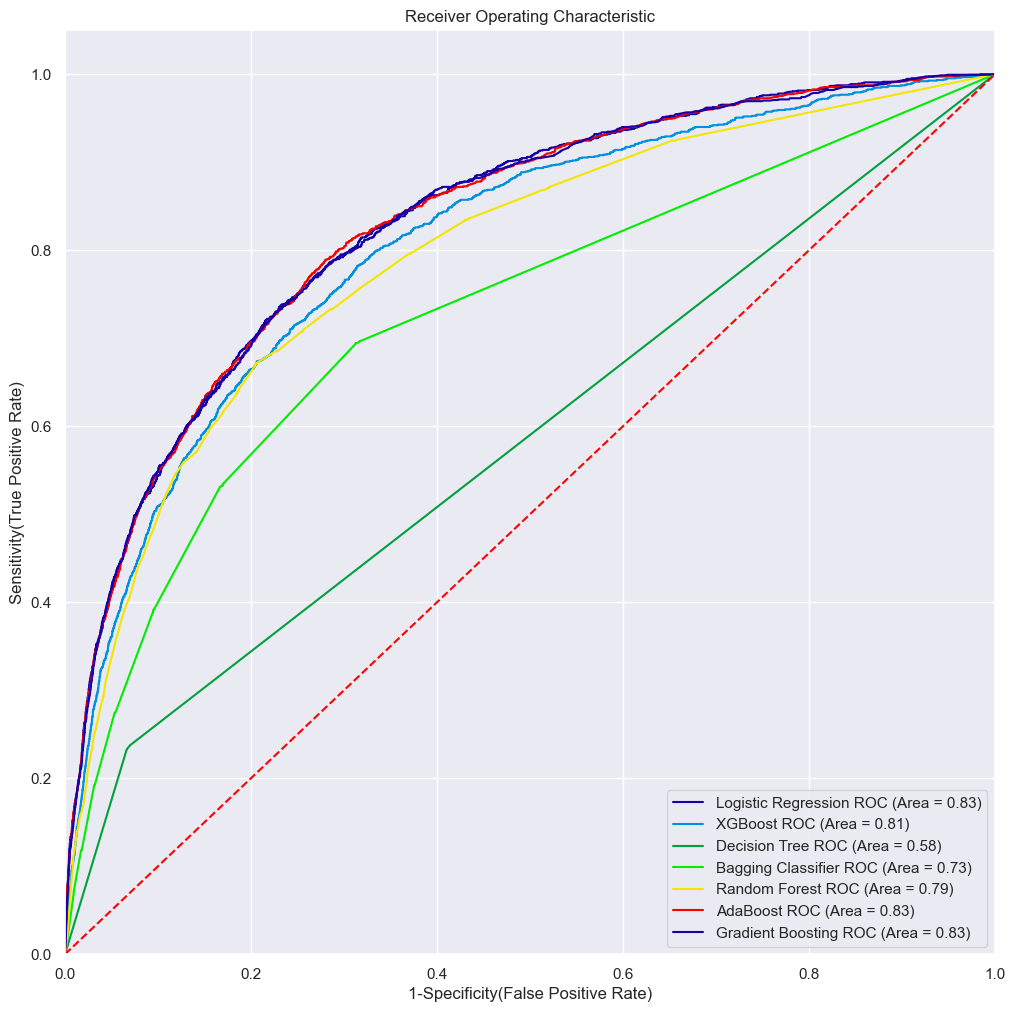

In [122]:
plt.figure(figsize=(12, 12))

# Add the models to the list that you want to view on the ROC plot
models = [{
    'label': 'Logistic Regression',
    'model': LogisticRegression()
}, {
    'label': 'XGBoost',
    'model': XGBClassifier(eval_metric='logloss')
}, {
    'label': 'Decision Tree',
    'model': DecisionTreeClassifier()
}, {
    'label': 'Bagging Classifier',
    'model': BaggingClassifier()
}, {
    'label': 'Random Forest',
    'model': RandomForestClassifier()
}, {
    'label': 'AdaBoost',
    'model': AdaBoostClassifier()
}, {
    'label': 'Gradient Boosting',
    'model': GradientBoostingClassifier(),
}]

# Below for loop iterates through your models list
for m in models:
    model = m['model']  # select the model
    model.fit(X_train, y_train)  # train the model
    y_pred = model.predict(X_test)  # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                             model.predict_proba(X_test)[:, 1])
    # Calculate Area under the curve to display on the plot
    auc_ = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::,1])
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (Area = %0.2f)' % (m['label'], auc_))
# Custom settings for the plot
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# Display
plt.show() 

**Precision Recall Curves**

In [123]:
# Define the function that will display every Precision-Recall curve


def plot_PR_curve(models):
    for m in models:
        model = m['model']
        model.fit(X_train, y_train)
        print('{}'.format(m['label']))
        # predict probabilities
        probs = model.predict_proba(X_test)
        # keep probabilities for the positive outcome only
        probs = probs[:, 1]
        # predict class values
        y_hat = model.predict(X_test)
        #calculate precision-recall curve
        precision, recall, thresholds = precision_recall_curve(y_test, probs)
        # calculate F1 score
        f1 = f1_score(y_test, y_hat)
        #calculate precision-recall AUC
        the_auc = auc(recall, precision)
        # Calculate average precision score
        ap = average_precision_score(y_test, probs)
        print('F1 score=%.3f AUC=%.3f Average Precision=%.3f' %
              (f1, the_auc, ap))

        plt.figure(figsize=[8, 7])
        # plot no skill (the blue line)
        plt.plot([0, 1], [0.1, 0.1], linestyle='--')
        # plot the precision-recall curve for the model
        plt.plot(recall,
                 precision,
                 marker='.',
                 label='%s ROC (Area = %0.2f)' % (m['label'], the_auc))
        plt.legend(loc='best')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve')
        plt.show()

Logistic Regression
F1 score=0.219 AUC=0.329 Average Precision=0.329


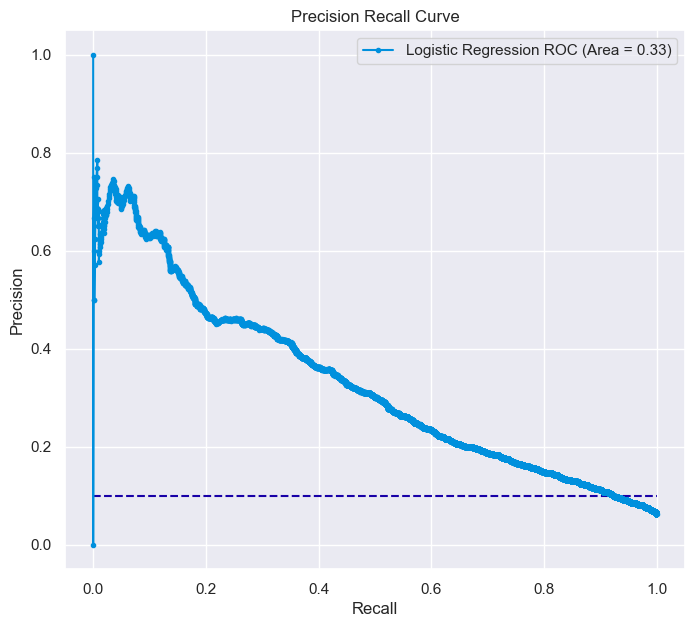

XGBoost
F1 score=0.191 AUC=0.270 Average Precision=0.271


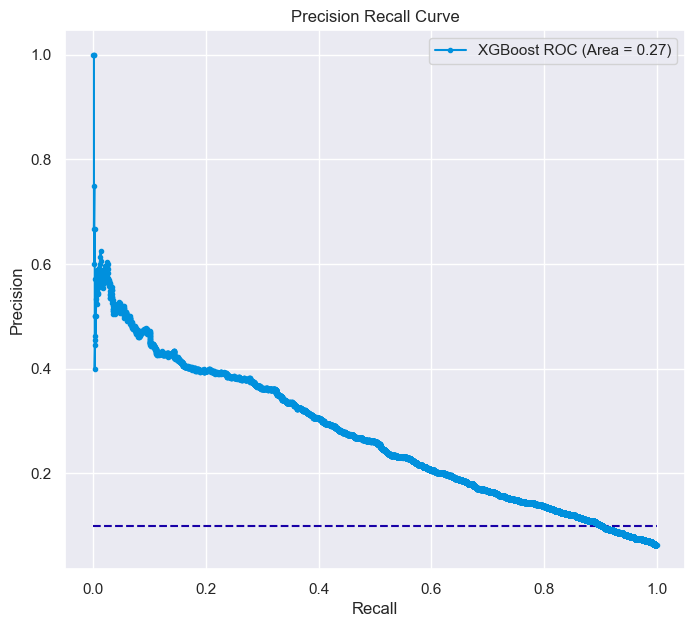

Decision Tree
F1 score=0.206 AUC=0.230 Average Precision=0.092


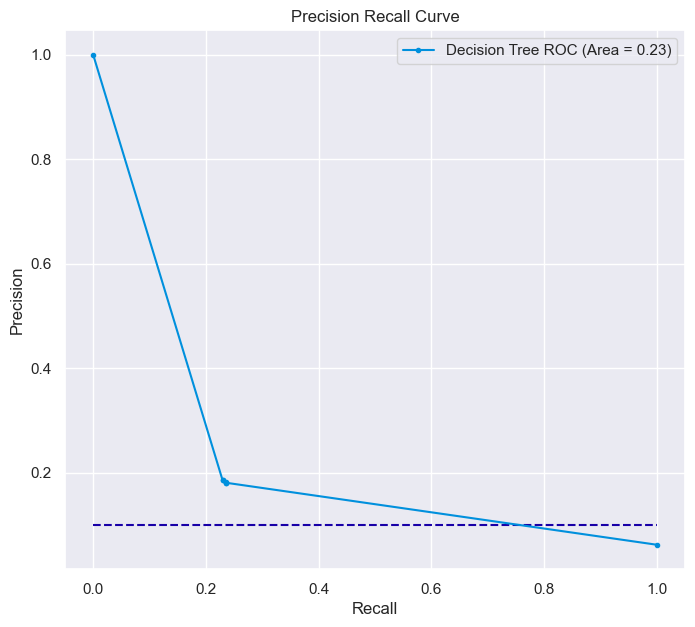

Bagging Classifier
F1 score=0.193 AUC=0.202 Average Precision=0.180


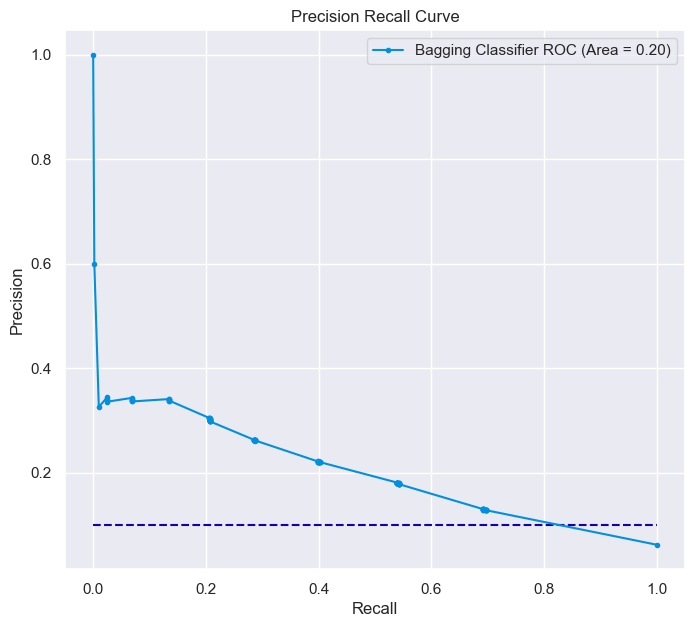

Random Forest
F1 score=0.128 AUC=0.246 Average Precision=0.243


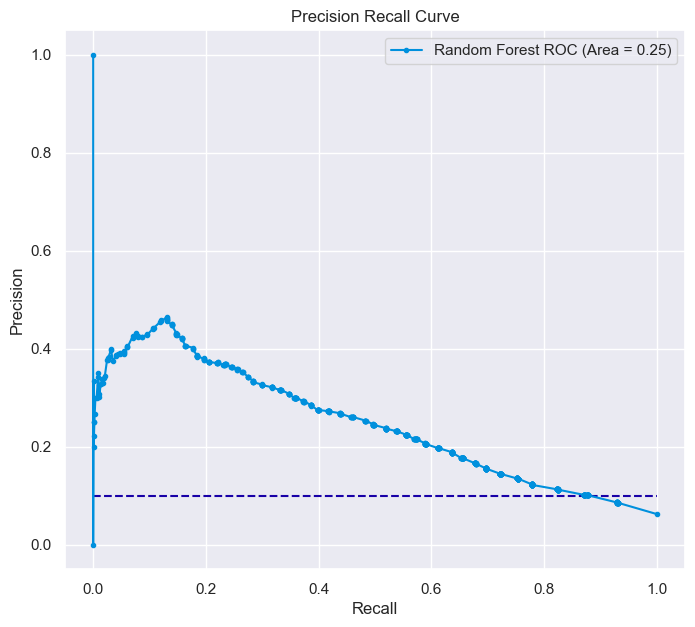

AdaBoost
F1 score=0.240 AUC=0.328 Average Precision=0.328


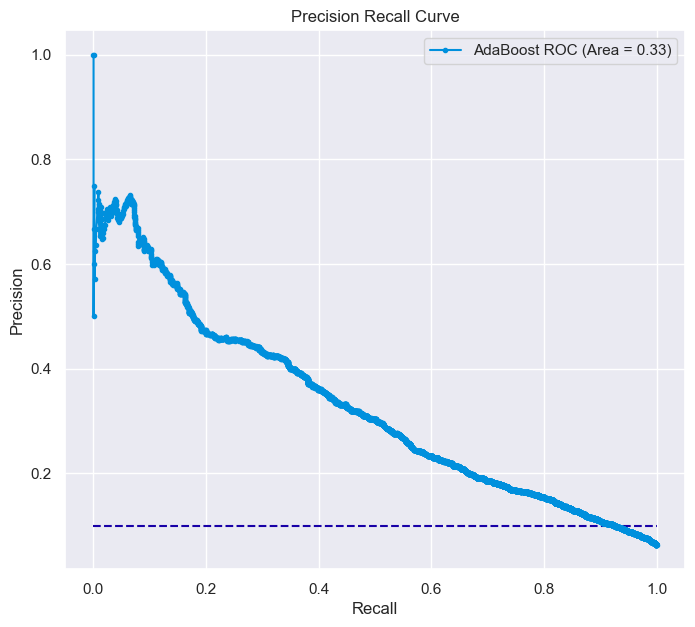

Gradient Boosting
F1 score=0.198 AUC=0.320 Average Precision=0.321


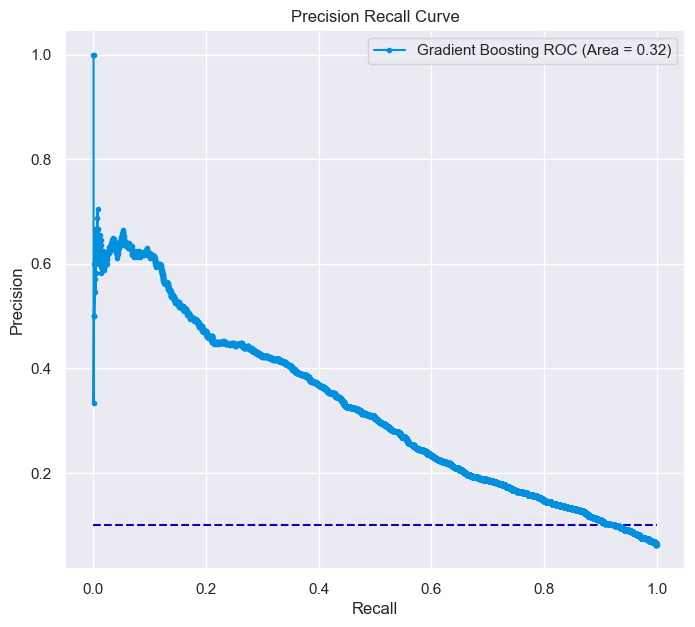

In [124]:
models = [
    {'label': 'Logistic Regression','model': LogisticRegression()}, 
    {'label': 'XGBoost','model': XGBClassifier(eval_metric='logloss')}, 
    {'label': 'Decision Tree','model': DecisionTreeClassifier()}, 
    {'label': 'Bagging Classifier','model': BaggingClassifier()}, 
    {'label': 'Random Forest','model': RandomForestClassifier()}, 
    {'label': 'AdaBoost','model': AdaBoostClassifier()}, 
    {'label': 'Gradient Boosting','model': GradientBoostingClassifier()}
]

plot_PR_curve(models)

From the above we have seen the performance of the basic predictive performance on the data. Let's progress using the following classifiers:
* Logistic Regression
* AdaBoost
* Gradient Boosting Methom (GBM)
* XGBoost

---

## Logistic Regression Model fitting

Accuracy on training set :  0.9381898849669928
Accuracy on test set :  0.9398063115712139
Recall on training set :  0.12660760217204917
Recall on test set :  0.13475650433622416
Precision on training set :  0.5261282660332541
Precision on test set :  0.5821325648414986
F1 Score on training set :  0.20410043768716887
F1 Score on test set :  0.21885157096424704


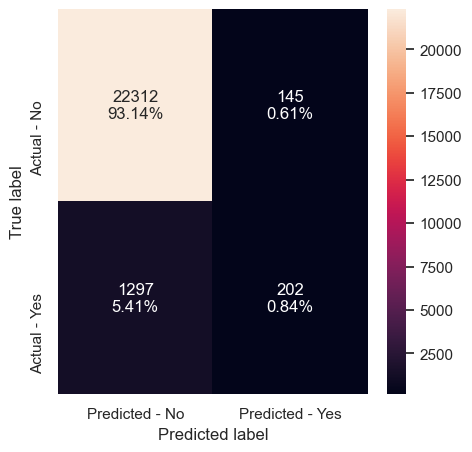

In [125]:
lr = LogisticRegression()
lr.fit(X_train, y_train)

#Calculating different metrics
get_metrics_score(lr, X_train, X_test, y_train, y_test)

# creating confusion matrix
make_confusion_matrix(lr, y_test)

* The LR model generalizes well and performs marginally better on the test data.

---

### LR Hyperparameter tuning

In [126]:
#Choose the type of classifier.
lr_estimator = LogisticRegression()

LRparam_grid = {
    'C': [1, 10, 100, 1000],
    'penalty': ['l1', 'l2'],
    'max_iter': list(range(100, 800, 100)),
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}

LR_search = GridSearchCV(estimator=lr_estimator,
                         param_grid=LRparam_grid,
                         scoring='f1',
                         refit=True,
                         cv=5)

# fitting the model for grid search
LR_result = LR_search.fit(X_train, y_train)

LR_result.best_estimator_

LogisticRegression(C=1, penalty='l1', solver='liblinear')

In [127]:
LR_result = LR_result.best_estimator_

Accuracy on training set :  0.93815410487146
Accuracy on test set :  0.9396810819836366
Recall on training set :  0.12775078593883968
Recall on test set :  0.13475650433622416
Precision on training set :  0.5246478873239436
Precision on test set :  0.5771428571428572
F1 Score on training set :  0.20547000689496667
F1 Score on test set :  0.21849648458626283


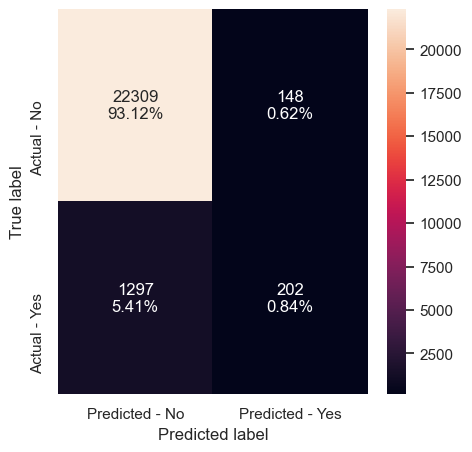

In [128]:
#Calculating different metrics
get_metrics_score(LR_result, X_train, X_test, y_train, y_test)

# creating confusion matrix
make_confusion_matrix(LR_result, y_test)

---

### LR AUC ROC curve

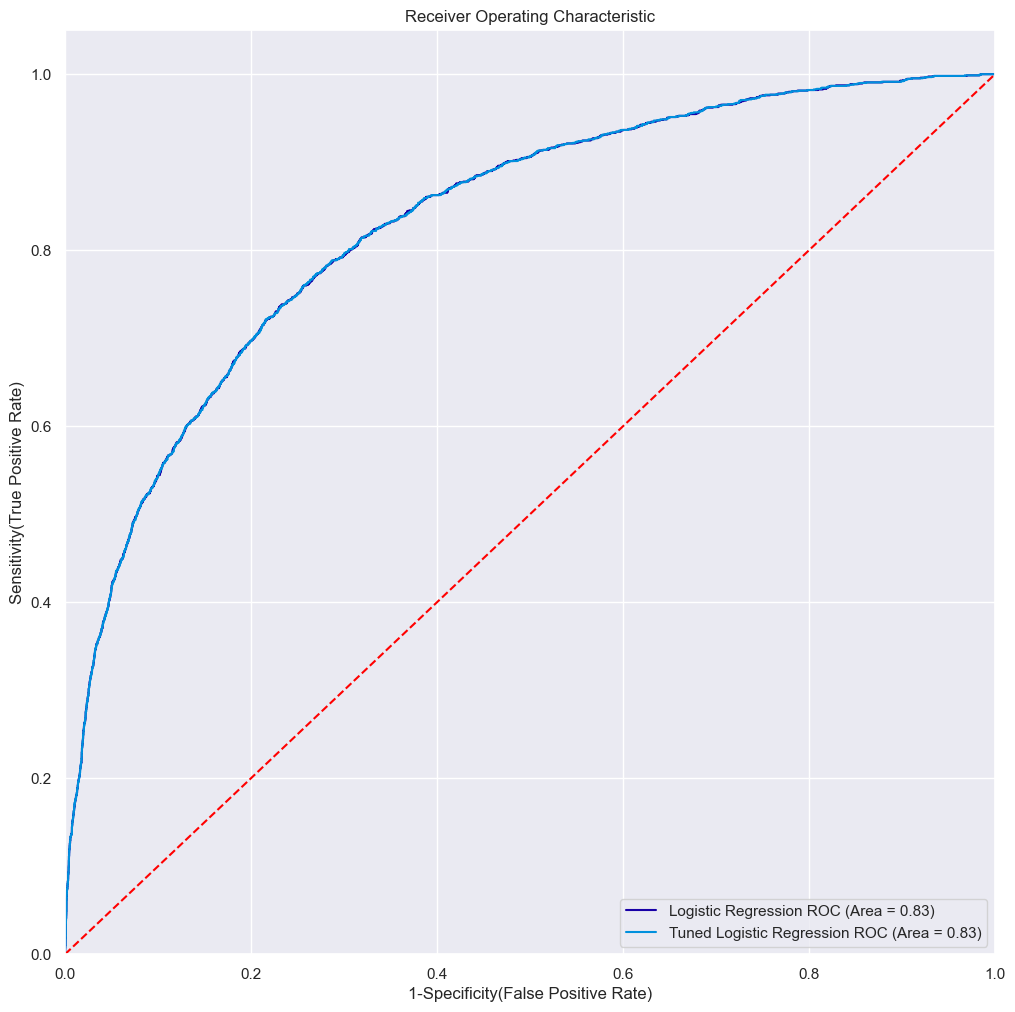

In [129]:
plt.figure(figsize=(12, 12))

# Add the models to the list that you want to view on the ROC plot
models = [{
    'label': 'Logistic Regression',
    'model': lr_estimator
}, {
    'label': 'Tuned Logistic Regression',
    'model': LR_result
}]

# Below for loop iterates through your models list
for m in models:
    model = m['model']  # select the model
    model.fit(X_train, y_train)  # train the model
    y_pred = model.predict(X_test)  # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                             model.predict_proba(X_test)[:, 1])
    # Calculate Area under the curve to display on the plot
    auc_ = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::,1])
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (Area = %0.2f)' % (m['label'], auc_))
# Custom settings for the plot
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# Display
plt.show() 

---

## AdaBoost Classifier

Accuracy on training set :  0.93815410487146
Accuracy on test set :  0.9392219068291868
Recall on training set :  0.14375535867390682
Recall on test set :  0.1534356237491661
Precision on training set :  0.5217842323651453
Precision on test set :  0.5515587529976019
F1 Score on training set :  0.22540891776831729
F1 Score on test set :  0.24008350730688938


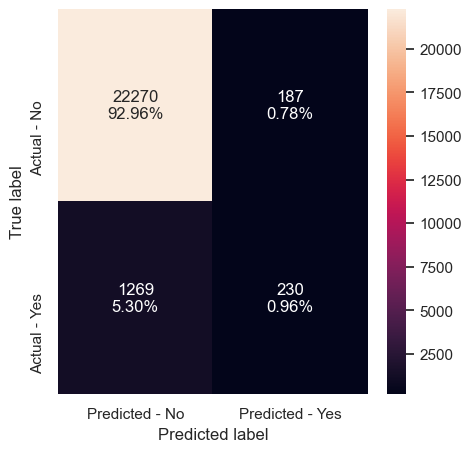

In [132]:
#Fitting the model
ab_classifier = AdaBoostClassifier(random_state=1)
ab_classifier.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(ab_classifier, X_train, X_test, y_train, y_test)

#Creating confusion matrix
make_confusion_matrix(ab_classifier,y_test)

* The AdaBoost model generalizes well and performs marginally better on the test data.

### Hyperparameter Tuning

In [133]:
%%time

# Choose the type of classifier.
abc = AdaBoostClassifier(random_state=1)

# Grid of parameters to choose from
parameters = {
    #Let's try different max_depth for base_estimator
    "base_estimator": [
        DecisionTreeClassifier(max_depth=1),
        DecisionTreeClassifier(max_depth=2),
        DecisionTreeClassifier(max_depth=3)
    ],
    "n_estimators":
    np.arange(10, 110, 10),
    "learning_rate":
    np.arange(0.1, 2, 0.1)
}

# Type of scoring used to compare parameter  combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

#Calling RandomizedSearchCV
abc_randomcv = RandomizedSearchCV(estimator=abc,
                               param_distributions=parameters,
                               n_iter=50,
                               scoring=acc_scorer,
                               cv=5,
                               refit=True,
                               random_state=1)

#Fitting parameters in RandomizedSearchCV
abc_tuned = abc_randomcv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:".format(
    abc_tuned.best_params_, abc_tuned.best_score_))

abc_tuned.best_estimator_

Best parameters are {'n_estimators': 10, 'learning_rate': 1.3000000000000003, 'base_estimator': DecisionTreeClassifier(max_depth=1)} with CV score=0.23909410533277936:
Wall time: 10min 18s


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=1.3000000000000003, n_estimators=10,
                   random_state=1)

In [134]:
abc_tuned=abc_tuned.best_estimator_

Accuracy on training set :  0.9367229010501458
Accuracy on test set :  0.9385122724995826
Recall on training set :  0.15718776793369535
Recall on test set :  0.1581054036024016
Precision on training set :  0.4833040421792619
Precision on test set :  0.5290178571428571
F1 Score on training set :  0.2372223420314859
F1 Score on test set :  0.24345146379044685


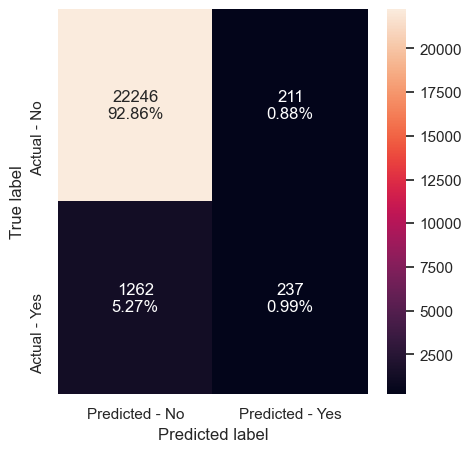

In [135]:
#Calculating different metrics
get_metrics_score(abc_tuned, X_train, X_test, y_train, y_test)

# creating confusion matrix
make_confusion_matrix(abc_tuned, y_test)

---

### Adaboost AUC ROC curve

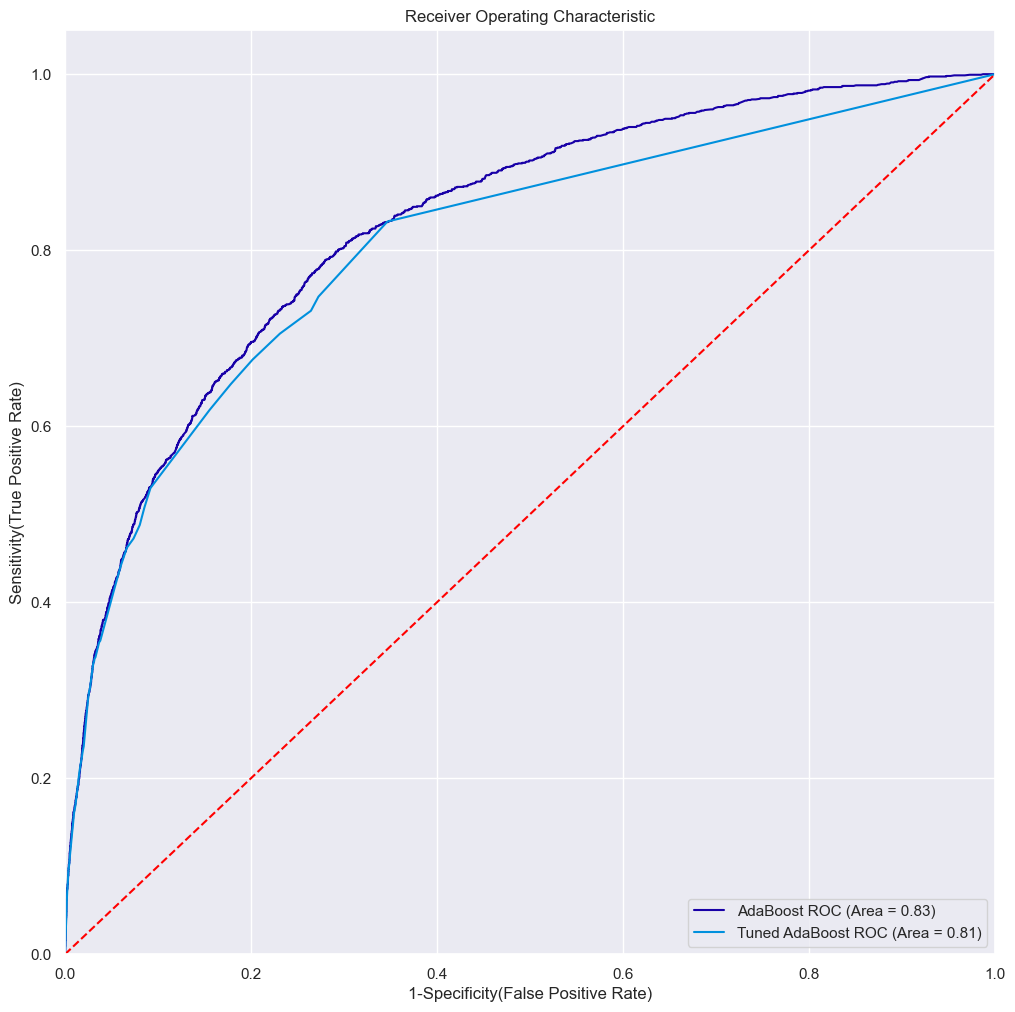

In [136]:
plt.figure(figsize=(12, 12))

# Add the models to the list that you want to view on the ROC plot
models = [{
    'label': 'AdaBoost',
    'model': AdaBoostClassifier()
}, {
    'label': 'Tuned AdaBoost',
    'model': abc_tuned
}]

# Below for loop iterates through your models list
for m in models:
    model = m['model']  # select the model
    model.fit(X_train, y_train)  # train the model
    y_pred = model.predict(X_test)  # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                             model.predict_proba(X_test)[:, 1])
    # Calculate Area under the curve to display on the plot
    auc_ = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::,1])
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (Area = %0.2f)' % (m['label'], auc_))
# Custom settings for the plot
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# Display
plt.show() 

---

## Gradient Boosting Classifier

Accuracy on training set :  0.9392990679285114
Accuracy on test set :  0.939848054767073
Recall on training set :  0.11431837667905116
Recall on test set :  0.11874583055370247
Precision on training set :  0.5763688760806917
Precision on test set :  0.5973154362416108
F1 Score on training set :  0.1907941807774863
F1 Score on test set :  0.19810795770728992


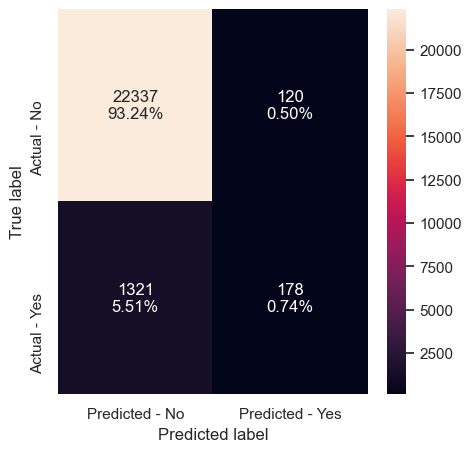

In [137]:
#Fitting the model
gb_classifier = GradientBoostingClassifier(random_state=1)
gb_classifier.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(gb_classifier, X_train, X_test, y_train, y_test)

#Creating confusion matrix
make_confusion_matrix(gb_classifier,y_test)

* The GBM model generalizes well and performs marginally better on the test data.

### Hyperparameter Tuning

In [138]:
%%time

# Choose the type of classifier. 
gbc = GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),random_state=1)

# Grid of parameters to choose from
parameters = {
    "n_estimators": [100,150,200],
    "subsample":[0.8,0.9,1],
    "max_features":[0.7,0.8,0.9,1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

#Calling RandomizedSearchCV
gbc_randomcv = RandomizedSearchCV(estimator=gbc,
                               param_distributions=parameters,
                               n_iter=50,
                               scoring=acc_scorer,
                               cv=5,
                               refit = True,
                               random_state=1)

#Fitting parameters in RandomizedSearchCV
gbc_tuned = gbc_randomcv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:".format(
    gbc_tuned.best_params_, gbc_tuned.best_score_))


gbc_tuned.best_estimator_

Best parameters are {'subsample': 0.9, 'n_estimators': 150, 'max_features': 0.8} with CV score=0.179019153336666:
Wall time: 17min 49s


GradientBoostingClassifier(init=AdaBoostClassifier(random_state=1),
                           max_features=0.8, n_estimators=150, random_state=1,
                           subsample=0.9)

In [139]:
gbc_tuned = gbc_tuned.best_estimator_

Accuracy on training set :  0.939531638549475
Accuracy on test set :  0.9396810819836366
Recall on training set :  0.12060588739639898
Recall on test set :  0.12274849899933289
Precision on training set :  0.5820689655172414
Precision on test set :  0.5859872611464968
F1 Score on training set :  0.19981060606060608
F1 Score on test set :  0.2029784886927744


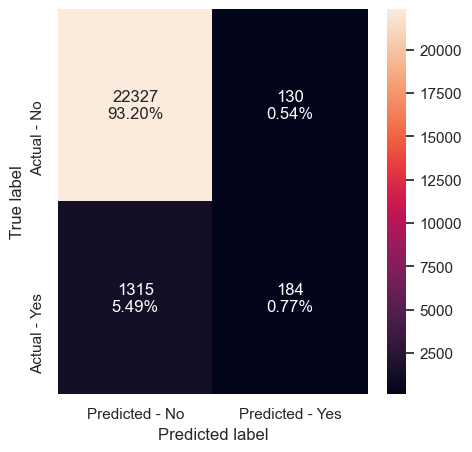

In [140]:
#Calculating different metrics
get_metrics_score(gbc_tuned, X_train, X_test, y_train, y_test)

#Creating confusion matrix
make_confusion_matrix(gbc_tuned,y_test)

---

### GBM AUC ROC curve

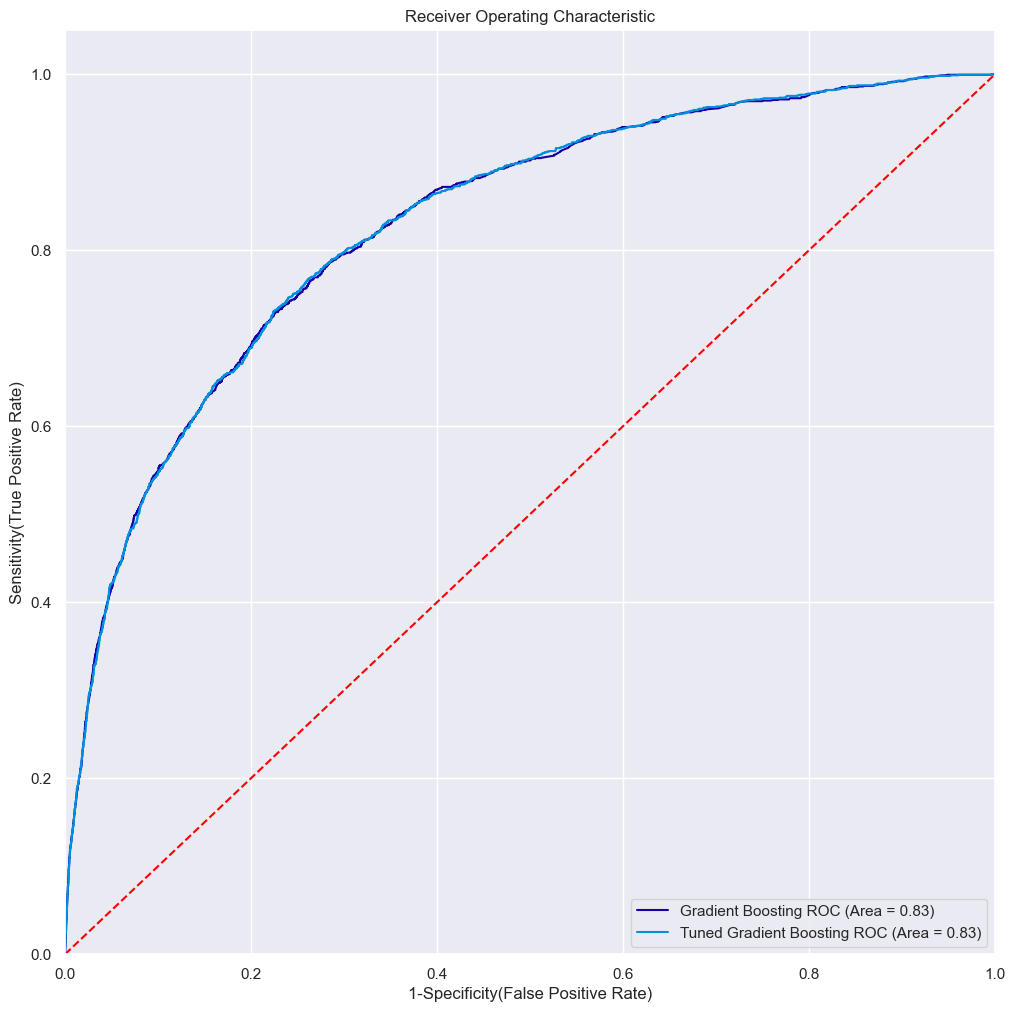

In [141]:
plt.figure(figsize=(12, 12))

# Add the models to the list that you want to view on the ROC plot
models = [{
    'label': 'Gradient Boosting',
    'model': gb_classifier
}, {
    'label': 'Tuned Gradient Boosting',
    'model': gbc_tuned
}]

# Below for loop iterates through your models list
for m in models:
    model = m['model']  # select the model
    model.fit(X_train, y_train)  # train the model
    y_pred = model.predict(X_test)  # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                             model.predict_proba(X_test)[:, 1])
    # Calculate Area under the curve to display on the plot
    auc_ = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::,1])
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (Area = %0.2f)' % (m['label'], auc_))
# Custom settings for the plot
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# Display
plt.show() 

---

## XGBoost Classifier

Accuracy on training set :  0.9525377032756678
Accuracy on test set :  0.9350475872432793
Recall on training set :  0.2797942269219777
Recall on test set :  0.12274849899933289
Precision on training set :  0.8803956834532374
Precision on test set :  0.4329411764705882
F1 Score on training set :  0.42463673823465625
F1 Score on test set :  0.19126819126819128


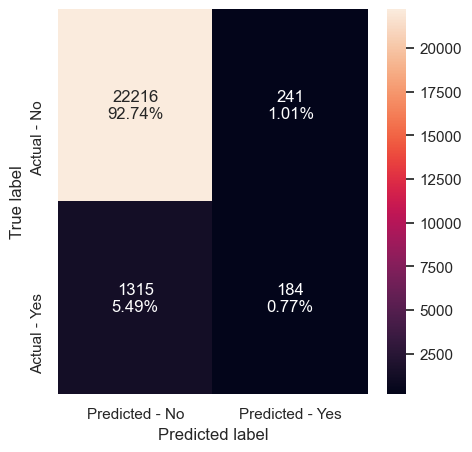

In [143]:
#Fitting the model
xgb_classifier = XGBClassifier(random_state=1,eval_metric= 'logloss')
xgb_classifier.fit(X_train,y_train)

#Calculating different metrics
get_metrics_score(xgb_classifier, X_train, X_test, y_train, y_test)

#Creating confusion matrix
make_confusion_matrix(xgb_classifier,y_test)

* The XGBoost model performs worst on the test data.

### Hyperparameter Tuning

In [144]:
%%time

# Choose the type of classifier.
xgb = XGBClassifier(random_state=1, eval_metric='logloss')

# Grid of parameters to choose from
parameters = {
    "n_estimators": np.arange(10, 100, 20),
    "scale_pos_weight": [0, 1, 2, 5],
    "subsample": [0.5, 0.7, 0.9],
    "learning_rate": [0.01, 0.05, 0.1]
}

# Type of scoring used to compare parameter combinations
acc_scorer = metrics.make_scorer(metrics.f1_score)

# # Run the grid search
# grid_obj = GridSearchCV(xgb_tuned, parameters, scoring=acc_scorer, cv=5)
# grid_obj = grid_obj.fit(X_train, y_train)

# # Set the clf to the best combination of parameters
# xgb_tuned = grid_obj.best_estimator_

# # Fit the best algorithm to the data.
# xgb_tuned.fit(X_train, y_train)

#Calling RandomizedSearchCV
xgb_randomcv = RandomizedSearchCV(estimator=xgb,
                               param_distributions=parameters,
                               n_iter=50,
                               scoring=acc_scorer,
                               refit=True,
                               cv=5,
                               random_state=1)

#Fitting parameters in RandomizedSearchCV
xgb_tuned = xgb_randomcv.fit(X_train, y_train)

print("Best parameters are {} with CV score={}:".format(
    xgb_tuned.best_params_, xgb_tuned.best_score_))

Best parameters are {'subsample': 0.7, 'scale_pos_weight': 5, 'n_estimators': 90, 'learning_rate': 0.05} with CV score=0.37135784385418896:
Wall time: 5min 8s


Accuracy on training set :  0.4288726280540741
Accuracy on test set :  0.3880510440835267
Recall on training set :  0.4941411831951986
Recall on test set :  0.44629753168779185
Precision on training set :  0.37883435582822084
Precision on test set :  0.34325295023088764
F1 Score on training set :  0.4288726280540741
F1 Score on test set :  0.3880510440835267


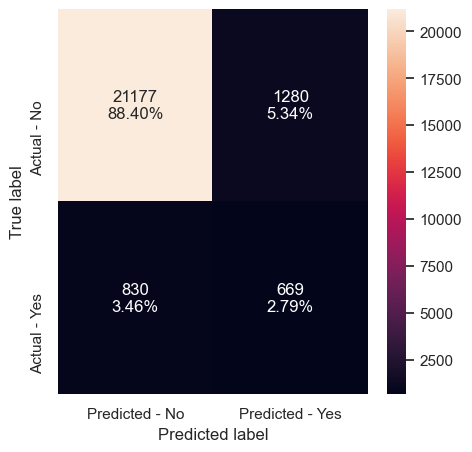

In [274]:
#Calculating different metrics
get_metrics_score(xgb_tuned, X_train, X_test, y_train, y_test)

#Creating confusion matrix
make_confusion_matrix(xgb_tuned,y_test)

---

### XGB AUC ROC curve

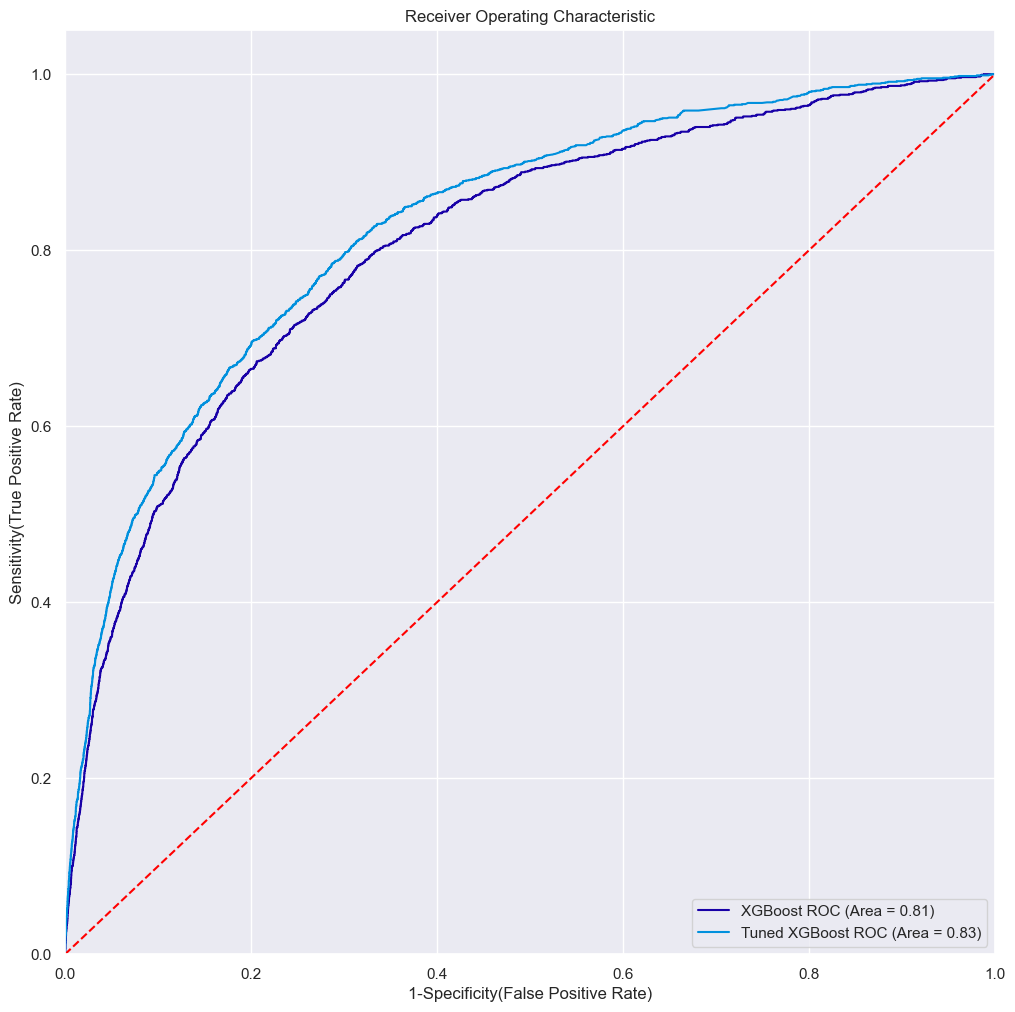

In [146]:
plt.figure(figsize=(12, 12))

# Add the models to the list that you want to view on the ROC plot
models = [{
    'label': 'XGBoost',
    'model': xgb_classifier
}, {
    'label': 'Tuned XGBoost',
    'model': xgb_tuned
}]

# Below for loop iterates through your models list
for m in models:
    model = m['model']  # select the model
    model.fit(X_train, y_train)  # train the model
    y_pred = model.predict(X_test)  # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                             model.predict_proba(X_test)[:, 1])
    # Calculate Area under the curve to display on the plot
    auc_ = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::,1])
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (Area = %0.2f)' % (m['label'], auc_))
# Custom settings for the plot
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# Display
plt.show() 

---

## Comparing all models

### AUC Curves

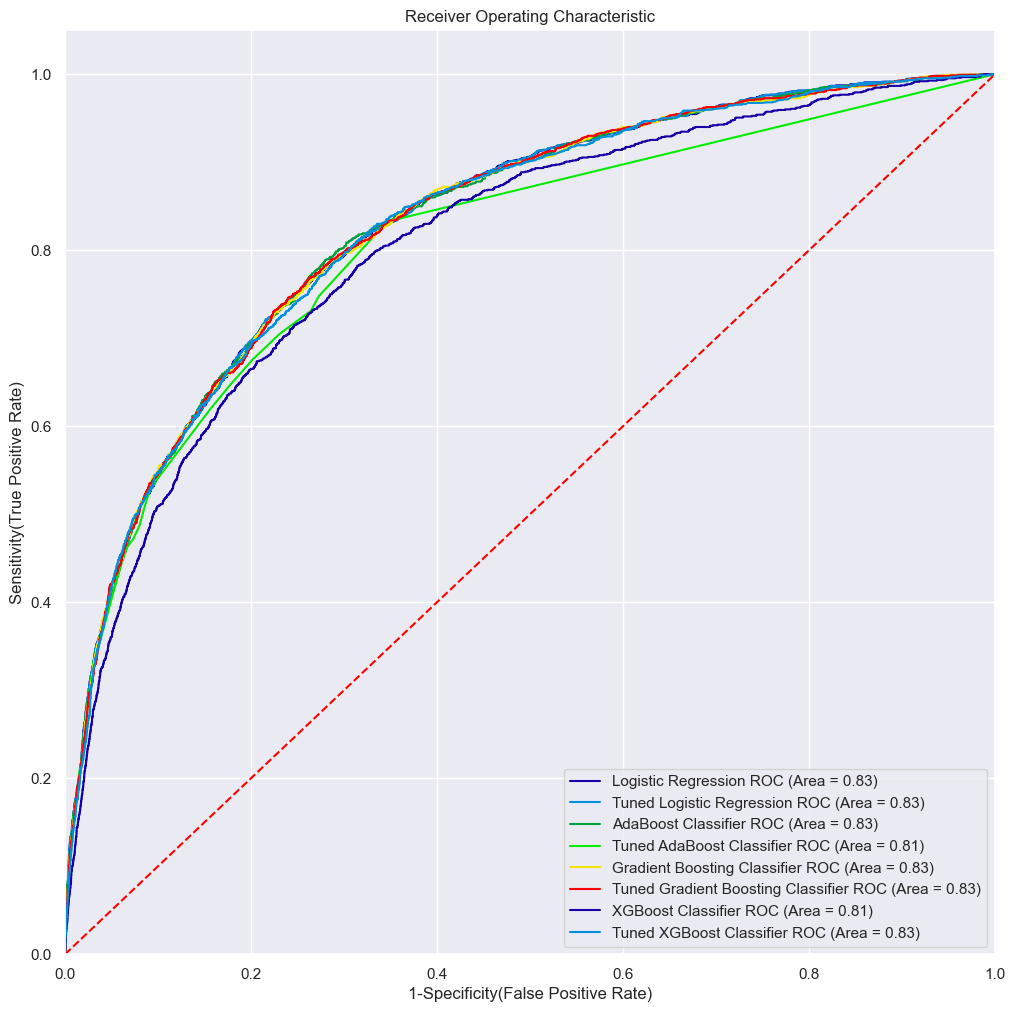

In [147]:
plt.figure(figsize=(12, 12))

# Add the models to the list that you want to view on the ROC plot
models = [{
    'label': 'Logistic Regression',
    'model': lr
}, {
    'label': 'Tuned Logistic Regression',
    'model': LR_result
}, {
    'label': 'AdaBoost Classifier',
    'model': ab_classifier
}, {
    'label': 'Tuned AdaBoost Classifier',
    'model': abc_tuned
}, {
    'label': 'Gradient Boosting Classifier',
    'model': gb_classifier
}, {
    'label': 'Tuned Gradient Boosting Classifier',
    'model': gbc_tuned
}, {
    'label': 'XGBoost Classifier',
    'model': xgb_classifier
}, {
    'label': 'Tuned XGBoost Classifier',
    'model': xgb_tuned
}]

# Below for loop iterates through your models list
for m in models:
    model = m['model']  # select the model
    model.fit(X_train, y_train)  # train the model
    y_pred = model.predict(X_test)  # predict the test data
    # Compute False postive rate, and True positive rate
    fpr, tpr, thresholds = metrics.roc_curve(y_test,
                                             model.predict_proba(X_test)[:, 1])
    # Calculate Area under the curve to display on the plot
    auc_ = metrics.roc_auc_score(y_test, model.predict_proba(X_test)[::,1])
    # Now, plot the computed values
    plt.plot(fpr, tpr, label='%s ROC (Area = %0.2f)' % (m['label'], auc_))
# Custom settings for the plot
plt.plot([0, 1], [0, 1], 'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
# Display
plt.show() 

### Precision Recall Curves

Logistic Regression
F1 score=0.219 AUC=0.329 Average Precision=0.329


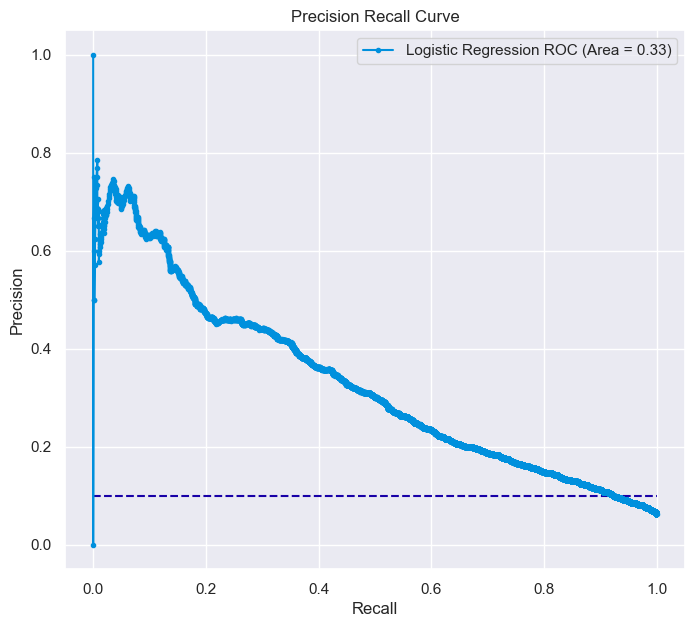

Tuned Logistic Regression
F1 score=0.218 AUC=0.329 Average Precision=0.329


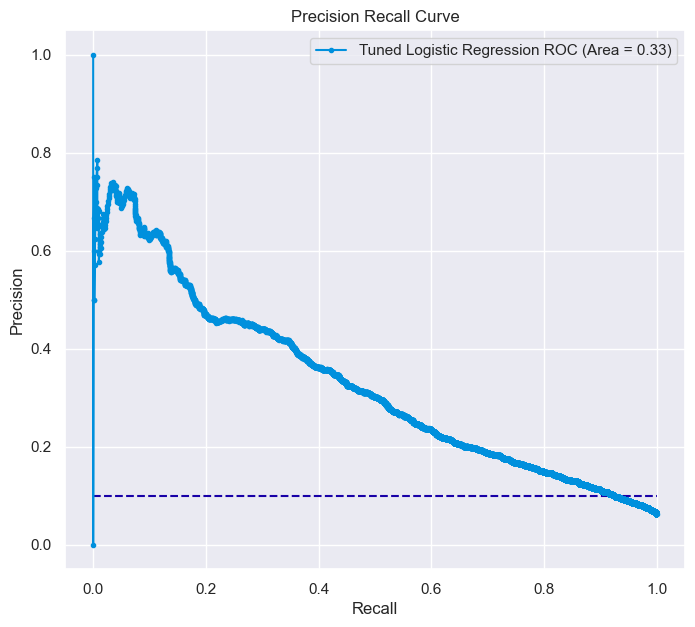

AdaBoost Classifier
F1 score=0.240 AUC=0.328 Average Precision=0.328


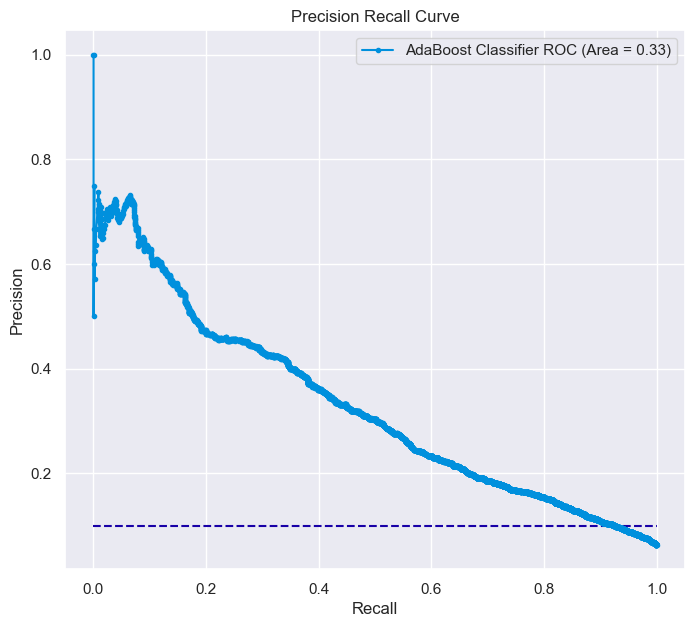

Tuned AdaBoost Classifier
F1 score=0.243 AUC=0.327 Average Precision=0.305


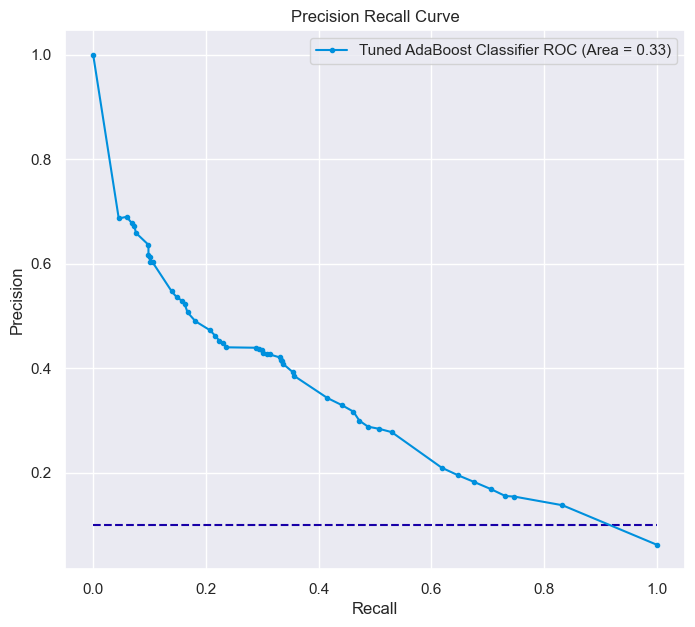

Gradient Boosting Classifier
F1 score=0.198 AUC=0.320 Average Precision=0.321


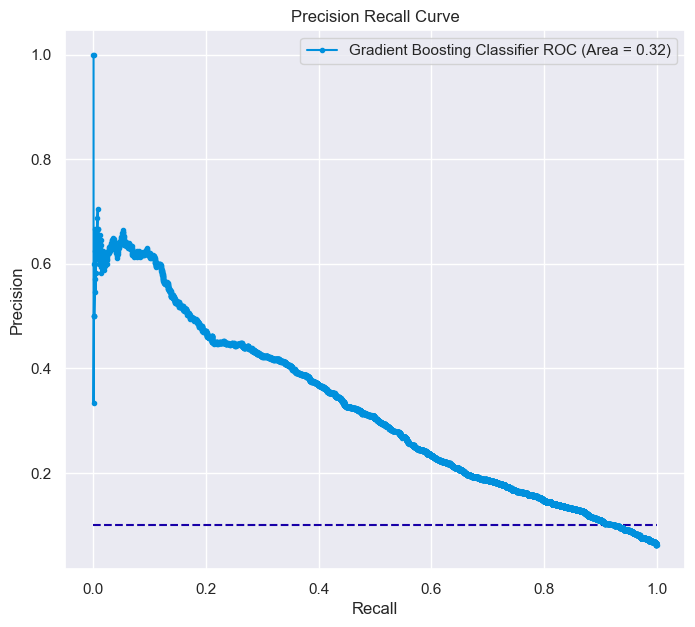

Tuned Gradient Boosting Classifier
F1 score=0.203 AUC=0.321 Average Precision=0.322


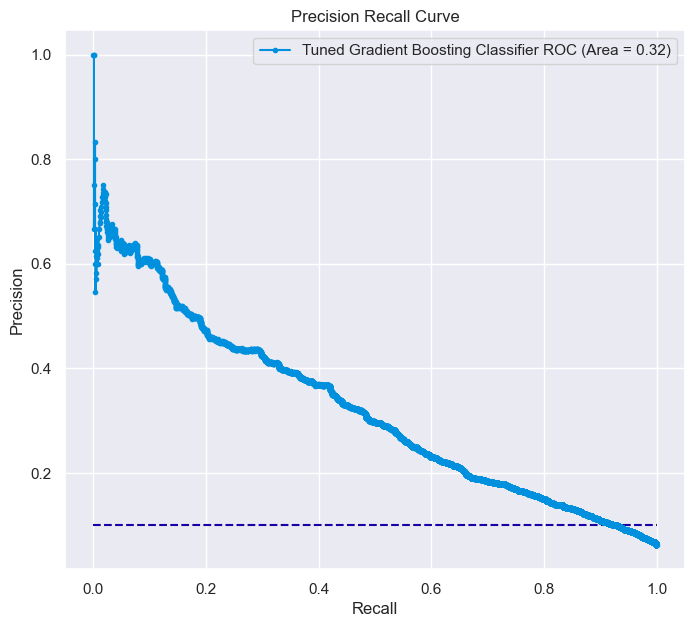

XGBoost Classifier
F1 score=0.191 AUC=0.270 Average Precision=0.271


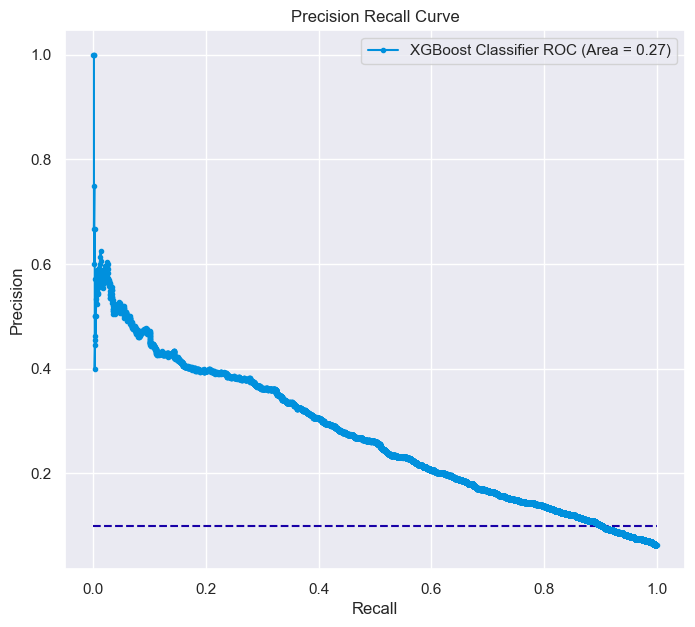

Tuned XGBoost Classifier
F1 score=0.388 AUC=0.315 Average Precision=0.316


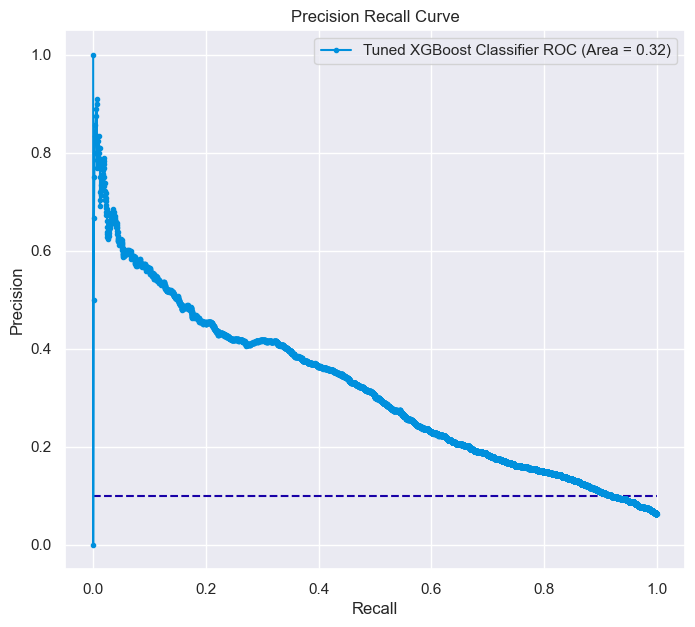

In [148]:
models = [{
    'label': 'Logistic Regression',
    'model': lr
}, {
    'label': 'Tuned Logistic Regression',
    'model': LR_result
}, {
    'label': 'AdaBoost Classifier',
    'model': ab_classifier
}, {
    'label': 'Tuned AdaBoost Classifier',
    'model': abc_tuned
}, {
    'label': 'Gradient Boosting Classifier',
    'model': gb_classifier
}, {
    'label': 'Tuned Gradient Boosting Classifier',
    'model': gbc_tuned
}, {
    'label': 'XGBoost Classifier',
    'model': xgb_classifier
}, {
    'label': 'Tuned XGBoost Classifier',
    'model': xgb_tuned
}]

from sklearn.metrics import auc


plot_PR_curve(models)

### Tabular 

In [149]:
# defining list of models
models = [
    lr, LR_result, ab_classifier, abc_tuned, gb_classifier, gbc_tuned,
    xgb_classifier, xgb_tuned
]

#           , pruned_dtree_model, dtree_estimator,rf_estimator, rf_tuned, bagging_classifier,bagging_estimator_tuned,
#           ab_classifier, abc_tuned, gb_classifier, gbc_tuned, xgb_classifier,xgb_tuned, stacking_classifier]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []
f1_score_train = []
f1_score_test = []

# looping through all the models to get the metrics score - Accuracy, Recall Precision and F1-Score
for model in models:

    j = get_metrics_score(model, X_train, X_test, y_train, y_test, False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])
    f1_score_train.append(j[6])
    f1_score_test.append(j[7])

In [150]:
comparison_frame = pd.DataFrame({
    'Model': [
        'Logistic Regression', 'Tuned Logistic Regression',
        'AdaBoost Classifier', 'Tuned AdaBoost Classifier',
        'Gradient Boosting Classifier', 'Tuned Gradient Boosting Classifier',
        'XGBoost Classifier', 'Tuned XGBoost Classifier'
    ],
    'Train_Accuracy':
    acc_train,
    'Test_Accuracy':
    acc_test,
    'Train_Recall':
    recall_train,
    'Test_Recall':
    recall_test,
    'Train_Precision':
    precision_train,
    'Test_Precision':
    precision_test,
    'Train_F1_Score':
    f1_score_train,
    'Test_F1_Score':
    f1_score_test,
})

#Sorting models in decreasing order of test recall
comparison_frame.sort_values(by='Test_F1_Score', ascending=False)

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision,Train_F1_Score,Test_F1_Score
7,Tuned XGBoost Classifier,0.428873,0.388051,0.494141,0.446298,0.378834,0.343253,0.428873,0.388051
3,Tuned AdaBoost Classifier,0.936723,0.938512,0.157188,0.158105,0.483304,0.529018,0.237222,0.243451
2,AdaBoost Classifier,0.938154,0.939222,0.143755,0.153436,0.521784,0.551559,0.225409,0.240084
0,Logistic Regression,0.938190,0.939806,0.126608,0.134757,0.526128,0.582133,0.204100,0.218852
1,Tuned Logistic Regression,0.938154,0.939681,0.127751,0.134757,0.524648,0.577143,0.205470,0.218496
5,Tuned Gradient Boosting Classifier,0.939532,0.939681,0.120606,0.122748,0.582069,0.585987,0.199811,0.202978
4,Gradient Boosting Classifier,0.939299,0.939848,0.114318,0.118746,0.576369,0.597315,0.190794,0.198108
6,XGBoost Classifier,0.952538,0.935048,0.279794,0.122748,0.880396,0.432941,0.424637,0.191268


---

In [151]:
models = [{
    'label': 'Logistic Regression',
    'model': lr
}, {
    'label': 'Tuned Logistic Regression',
    'model': LR_result
}, {
    'label': 'AdaBoost Classifier',
    'model': ab_classifier
}, {
    'label': 'Tuned AdaBoost Classifier',
    'model': abc_tuned
}, {
    'label': 'Gradient Boosting Classifier',
    'model': gb_classifier
}, {
    'label': 'Tuned Gradient Boosting Classifier',
    'model': gbc_tuned
}, {
    'label': 'XGBoost Classifier',
    'model': xgb_classifier
}, {
    'label': 'Tuned XGBoost Classifier',
    'model': xgb_tuned
}]

# defining empty lists to add test results
test_precision = []
test_recall = []
test_f1_score = []
test_AUC = []

# looping through all the models to get the metrics scores
for m in models:
    model = m['model']
    model.fit(X_train, y_train)
    # predict probabilities
    probs = model.predict_proba(X_test)
    # keep probabilities for the positive outcome only
    probs = probs[:, 1]
    # predict class values
    y_hat = model.predict(X_test)
    # Calculate precision-recall curve
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    # Calculate F1 score
    f1 = f1_score(y_test, y_hat)
    # Calculate precision-recall AUC
    the_auc = auc(recall, precision)
    # appending test value results to empty list
    test_precision.append(precision)
    test_recall.append(recall)
    test_f1_score.append(f1)
    test_AUC.append(the_auc)

In [152]:
comp_frame = pd.DataFrame({
    'Model': [
        'Logistic Regression', 'Tuned Logistic Regression',
        'AdaBoost Classifier', 'Tuned AdaBoost Classifier',
        'Gradient Boosting Classifier', 'Tuned Gradient Boosting Classifier',
        'XGBoost Classifier', 'Tuned XGBoost Classifier'
    ],

    'Test_F1_Score':
    test_f1_score,
    'Test_AUC_Score':
    test_AUC,
})

#Sorting models in decreasing order of test recall
comp_frame.sort_values(by='Test_AUC_Score', ascending=False)

,Model,Test_F1_Score,Test_AUC_Score
0,Logistic Regression,0.218852,0.328717
1,Tuned Logistic Regression,0.218496,0.328658
2,AdaBoost Classifier,0.240084,0.327749
3,Tuned AdaBoost Classifier,0.243451,0.327109
5,Tuned Gradient Boosting Classifier,0.202978,0.321295
4,Gradient Boosting Classifier,0.198108,0.320212
7,Tuned XGBoost Classifier,0.388051,0.315049
6,XGBoost Classifier,0.191268,0.270132


---

## Model Selection - Logistic Regression



From the models, above we have seen that the Logistic Regression model produced the highest AUC scores

Let's find the optimal probability cut off and adjust the model to get the best confusion matrix

In [236]:
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

lr.fit(X_train, y_train)
# predict probabilities
yhat = lr.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = yhat[:, 1]
# define thresholds
thresholds = np.arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(probs, t)) for t in thresholds]
# get best threshold
ix = np.argmax(scores)
Opt_threshold = thresholds[ix]
print('Threshold=%.3f, F-Score=%.5f' % (thresholds[ix], scores[ix]))

Threshold=0.173, F-Score=0.38645


Since the data was heavily imbalanced, the Threshold value was found to be **0.173**

Lets modify the probability cutoff to match the optimal threshold

In [243]:
# the probability of being y=1
train_pred=lr.predict_proba(X_train)[:,1]
test_pred=lr.predict_proba(X_test)[:,1]

opt_train_pred=[1 if i > Opt_threshold else 0 for i in train_pred]
opt_test_pred=[1 if i > Opt_threshold else 0 for i in test_pred]

---

**Define simple confusion matric visualization**

In [226]:
def conf_matrix(y_actual, y_predict, labels=[1, 0]):
    '''
    y_predict: prediction of class
    y_actual : ground truth  
    '''
    cm = confusion_matrix(y_actual, y_predict, labels=[0, 1])
    df_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ['Predicted - No', 'Predicted - Yes']])

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = [
        "{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)
    ]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]

    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(5, 5))
    sns.heatmap(df_cm, annot=labels, fmt='')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Accuracy on train data: 0.9132690484283593
Recall on train data: 0.4161188911117462
Precision on train data: 0.34170382539310024
f1 score on train data: 0.3752577319587629


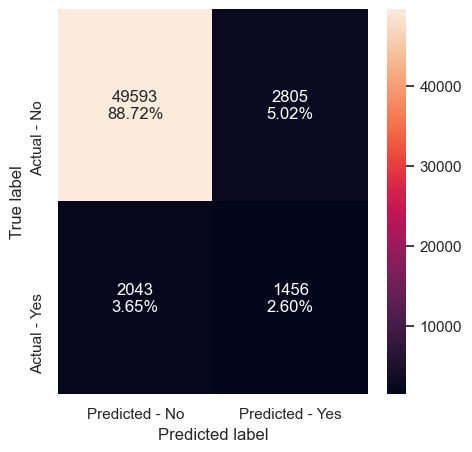

In [251]:
print('Accuracy on train data:', accuracy_score(y_train, opt_train_pred))
print('Recall on train data:', recall_score(y_train, opt_train_pred))
print('Precision on train data:', precision_score(y_train, opt_train_pred))
print('f1 score on train data:', f1_score(y_train, opt_train_pred))

# let us make confusion matrix on train set
conf_matrix(y_train,opt_train_pred)

Accuracy on test data: 0.9160961763232593
Recall on test data: 0.42228152101400934
Precision on test data: 0.3562183455261677
f1 score on test data: 0.38644688644688646


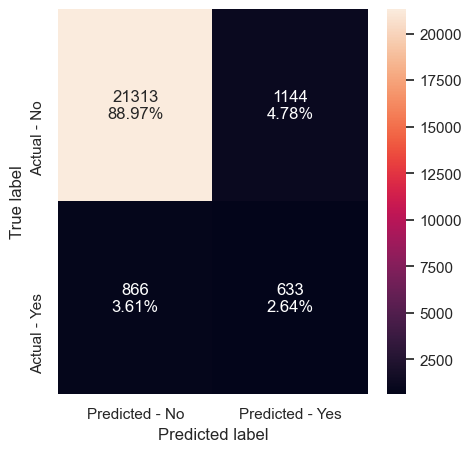

In [249]:
print('Accuracy on test data:', accuracy_score(y_test, opt_test_pred))
print('Recall on test data:', recall_score(y_test, opt_test_pred))
print('Precision on test data:', precision_score(y_test, opt_test_pred))
print('f1 score on test data:', f1_score(y_test, opt_test_pred))

# let us make confusion matrix on test set
conf_matrix(y_test, opt_test_pred)

* The F1 Score from the confusion matrix matches the F1 score when calculating the optimal threshold.

---

## Feature importances

In [217]:
## Coefficients of all the attributes with Name and Values as separate column
Coeff_Col_df = pd.DataFrame()
Coeff_Col_df['Col'] = X_train.columns
Coeff_Col_df['Coeff'] = np.round(abs(lr.coef_[0]), 2)
print("Shape of Coeff DF-->", Coeff_Col_df.shape)
print('')
print("Coefficients of all the attributes with Name and Values:")
Coeff_Col_df.sort_values(by='Coeff', ascending=False)

Shape of Coeff DF--> (44, 2)

Coefficients of all the attributes with Name and Values:


,Col,Coeff
8,Perc_premium_paid_in_cash_0.9 - 1,1.62
10,Late_premium_payment_6-12_months_Paid_on_time,1.49
7,Perc_premium_paid_in_cash_0.8 - 0.9,1.46
6,Perc_premium_paid_in_cash_0.7 - 0.8,1.37
5,Perc_premium_paid_in_cash_0.6 - 0.7,1.18
4,Perc_premium_paid_in_cash_0.5 - 0.6,1.04
11,Late_premium_payment_>12_months_Paid_on_time,1.04
9,Late_premium_payment_3-6_months_Paid_on_time,0.90
22,No_of_premiums_paid_>20,0.86
3,Perc_premium_paid_in_cash_0.4 - 0.5,0.83


In [254]:
# Top 15 dummy variables which influence Loan selection
Coeff_Col_df.sort_values(by='Coeff', ascending=False).head(15)

,Col,Coeff
8,Perc_premium_paid_in_cash_0.9 - 1,1.62
10,Late_premium_payment_6-12_months_Paid_on_time,1.49
7,Perc_premium_paid_in_cash_0.8 - 0.9,1.46
6,Perc_premium_paid_in_cash_0.7 - 0.8,1.37
5,Perc_premium_paid_in_cash_0.6 - 0.7,1.18
4,Perc_premium_paid_in_cash_0.5 - 0.6,1.04
11,Late_premium_payment_>12_months_Paid_on_time,1.04
9,Late_premium_payment_3-6_months_Paid_on_time,0.90
22,No_of_premiums_paid_>20,0.86
3,Perc_premium_paid_in_cash_0.4 - 0.5,0.83


In [252]:
# Last 10 dummy variables which influence Loan selection
Coeff_Col_df.sort_values(by='Coeff', ascending=False).tail(10)

,Col,Coeff
28,Premium_payment_5000 - 10000,0.05
17,No_of_dependents_Two,0.03
37,Income_'000_60 - 100,0.02
14,Vehicles_Owned_Two,0.02
27,Customer_demographic_Urban,0.02
29,Premium_payment_10000 - 15000,0.02
18,Accomodation_Rented,0.01
30,Premium_payment_15000 - 20000,0.00
13,Vehicles_Owned_Three,0.00
16,No_of_dependents_Three,0.00


The following variables were found the greatest predictors of policy holders defaulting:
* **Perc_premium_paid_in_cash**
    * The greater the percentage of premium paid in cash, the greater the defaulting potential
* **Late_premium_payment_3-6_months_Paid_on_time**
* **Late_premium_payment_6-12_months_Paid_on_time**
* **Late_premium_payment_>12_months_Paid_on_time**
* **No_of_premiums_paid**
    * The greater the number of premium paid , the greater the defaulting potential
* **Age**
    * The oldest policy holders had the greatest potential to default
* **Income**
    * The highest income earners had the greatest potential to default 


---


---

## SMOTE

Since the data was heavily imbalanced. Let's run SMOTE and observe if it would produce a better model

### Oversampling train data using SMOTE

In [ ]:
pip install imblearn

In [264]:
from imblearn.over_sampling import SMOTE

In [265]:
print("Before UpSampling, counts of label 'Default': {}".format(sum(y_train == 1)))
print("Before UpSampling, counts of label 'Not_Default': {} \n".format(sum(y_train == 0)))

# Synthetic Minority Over Sampling Technique
sm = SMOTE(sampling_strategy=1, k_neighbors=5, random_state=1)
X_train_over, y_train_over = sm.fit_resample(X_train, y_train)


print("After UpSampling, counts of label 'Default': {}".format(sum(y_train_over == 1)))
print("After UpSampling, counts of label 'Not_Default': {} \n".format(sum(y_train_over == 0)))


print('After UpSampling, the shape of train_X: {}'.format(X_train_over.shape))
print('After UpSampling, the shape of train_y: {} \n'.format(y_train_over.shape))

Before UpSampling, counts of label 'Default': 3499
Before UpSampling, counts of label 'Not_Default': 52398 

After UpSampling, counts of label 'Default': 52398
After UpSampling, counts of label 'Not_Default': 52398 

After UpSampling, the shape of train_X: (104796, 44)
After UpSampling, the shape of train_y: (104796,) 



---

#### Logistic Regression on oversampled data

In [266]:
log_reg_over = LogisticRegression(random_state = 1)

# Training the basic logistic regression model with training set 
log_reg_over.fit(X_train_over,y_train_over)

LogisticRegression(random_state=1)

Accuracy on training set :  0.933938318256422
Accuracy on test set :  0.9307062948739355
Recall on training set :  0.8776861712279095
Recall on test set :  0.038692461641094064
Precision on training set :  0.9889469496591617
Precision on test set :  0.20938628158844766
F1 Score on training set :  0.9300007077784855
F1 Score on test set :  0.06531531531531533


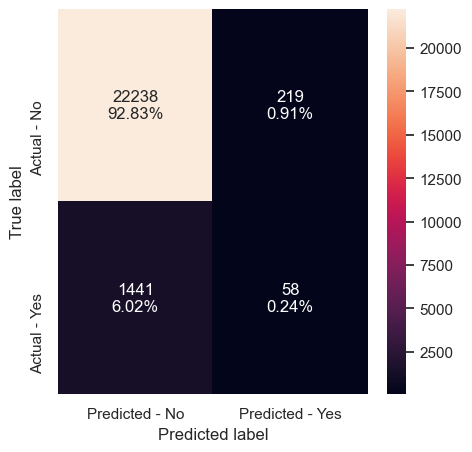

In [267]:
# Calculating different metrics
get_metrics_score(log_reg_over, X_train_over, X_test, y_train_over, y_test)

# creating confusion matrix
make_confusion_matrix(log_reg_over, y_test)

* With the application of SMOTE oversampling, the training performance is significantly better but the testing performance is abismal.

Let's explore Regularization and Undersampling to see its performance will be better or worse.

---

### Undersampling train data using SMOTE

In [268]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=1)
X_train_un, y_train_un = rus.fit_resample(X_train, y_train)

In [269]:
print("Before Under Sampling, counts of label 'Default': {}".format(sum(y_train == 1)))
print("Before Under Sampling, counts of label 'Not_Default': {} \n".format(sum(y_train == 0)))

print("After Under Sampling, counts of label 'Default': {}".format(sum(y_train_un == 1)))
print("After Under Sampling, counts of label 'Not_Default': {} \n".format(sum(y_train_un == 0)))

print('After Under Sampling, the shape of train_X: {}'.format(X_train_un.shape))
print('After Under Sampling, the shape of train_y: {} \n'.format(y_train_un.shape))

Before Under Sampling, counts of label 'Default': 3499
Before Under Sampling, counts of label 'Not_Default': 52398 

After Under Sampling, counts of label 'Default': 3499
After Under Sampling, counts of label 'Not_Default': 3499 

After Under Sampling, the shape of train_X: (6998, 44)
After Under Sampling, the shape of train_y: (6998,) 



---

#### Logistic Regression on undersampled data

In [270]:
log_reg_under = LogisticRegression(random_state=1)
log_reg_under.fit(X_train_un, y_train_un)

LogisticRegression(random_state=1)

Accuracy on training set :  0.7655044298370963
Accuracy on test set :  0.7735849056603774
Recall on training set :  0.7356387539296942
Recall on test set :  0.7184789859906604
Precision on training set :  0.782370820668693
Precision on test set :  0.17716729725283764
F1 Score on training set :  0.758285461776403
F1 Score on test set :  0.2842438638163104


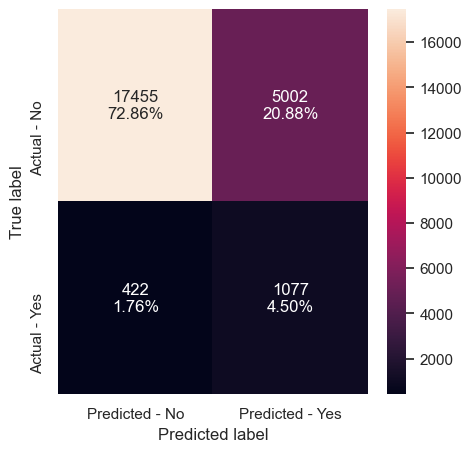

In [271]:
#Calculating different metrics
get_metrics_score(log_reg_under, X_train_un, X_test, y_train_un, y_test)

# creating confusion matrix
make_confusion_matrix(log_reg_under, y_test)

* The Undersampled model generalizes on Accuracy and Recall performs better on the training data.

Neither SMOTE Oversampling nor Undersampling performed better than the LR model which was adjusted for the optimal threshold.

---

---

---

---